In [1]:
import pandas as pd
import logomaker
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
import coopgcpbm.modeler.plotlib as pl

## 1. Analysis on d=4 for ETS1-ETS1
Since we want to get information about anticoop, I created a training data that retains all information (i.e., it includes the anticoop and fail_cutoff sequences).

In [3]:
train_ee = pd.read_csv("train_ets1_ets1_w_anticoop.tsv", sep="\t")
train_ee_d4 = train_ee[train_ee["distance"] == 4]

### 1.a. Consensus motif for d=4
It looks like ETS1-ETS1 d=4 follows a specific GGAAGGAA composite motif with differences in the flanking regions.

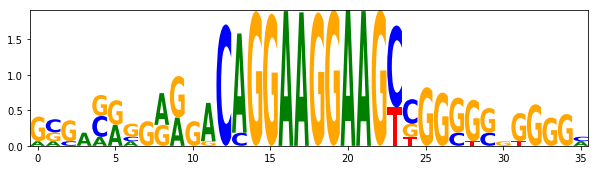

In [4]:
m = logomaker.alignment_to_matrix(train_ee_d4["Sequence"].tolist(), to_type="weight")
m[m < 0] = 0
logomaker.Logo(m)

Motifs from just the cooperative sequences are similar from the d=4 sequences in general

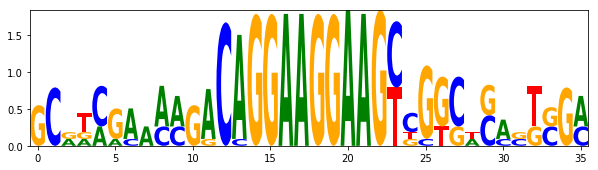

In [5]:
coop_ambiguous_seqs_d4 = train_ee_d4[train_ee_d4["label"] == "cooperative"]["Sequence"].tolist()
m = logomaker.alignment_to_matrix(coop_ambiguous_seqs_d4, to_type="weight")
m[m < 0] = 0
logomaker.Logo(m)

### 1.b. Label counts per orientation for d=4
Note that we converted all -/- into +/+

In [6]:
train_ee_d4[["orientation", "label"]].value_counts()

orientation  label          
+/+          cooperative        26
             fail_cutoff        24
             ambiguous          19
             independent        11
             anticooperative     2
-/+          ambiguous           1
+/-          fail_cutoff         1
dtype: int64

### 1.c. Binding site strength for d=4
Same conclusion as the general ETS1-ETS1 conclusion for the binding strength although it seems that the independent sequences have a very specific motifs for the stronger site,

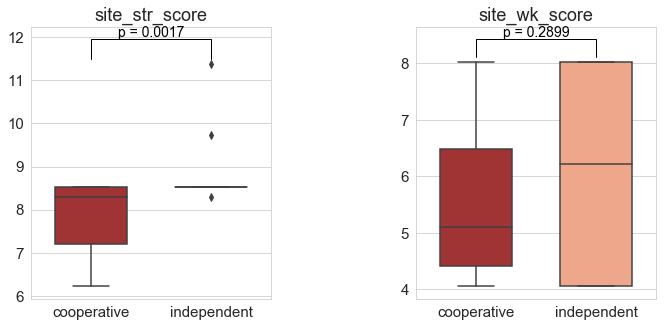

In [7]:
train_ee_d4_filtered = train_ee_d4[(train_ee_d4["label"] == "cooperative") | (train_ee_d4["label"] == "independent") ]
pl.plot_box_categories(train_ee_d4_filtered, incols=["site_str_score", "site_wk_score"], alternative="smaller", color = ["#b22222","#FFA07A"])
plt.show()

## 2. PWM binding scores vs ChIP-seq signals
Currently using all sequences instead of independent only

In [8]:
chip_ets1_k562 = pd.read_csv("chipseq_ets1_k562.tsv", sep="\t").rename(columns = {"sequence":"Sequence"})

In [9]:
pwm_vs_chip_k562 = chip_ets1_k562[["Sequence", "pileup_score"]]. \
        merge(train_ee[["Sequence","site_str_score", "site_wk_score"]],on="Sequence"). \
        rename(columns = {"site_str_score": "stronger_site", "site_wk_score": "weaker_site"})
print("#sequences in chip_k562 and ets1-ets1 training data:", pwm_vs_chip_k562.shape[0])

#sequences in chip_k562 and ets1-ets1 training data: 283


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


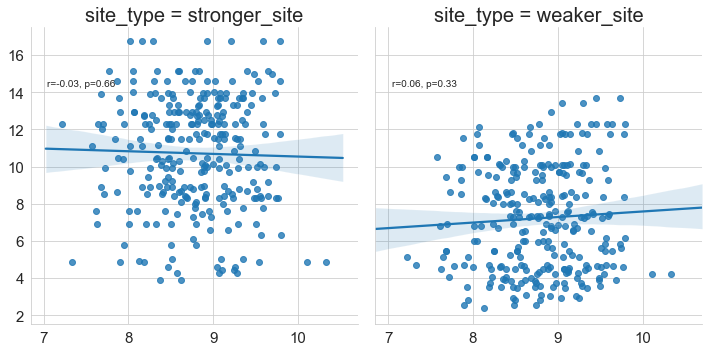

In [10]:
pwm_vs_chip_k562 = pd.melt(pwm_vs_chip_k562, id_vars=['Sequence', 'pileup_score'], 
                           value_vars=['stronger_site', 'weaker_site'],
                           var_name='site_type', value_name='pwm_score')
g=sns.lmplot(x='pileup_score', y='pwm_score', col="site_type" , data=pwm_vs_chip_k562)
def annotate(data, **kws):
    r, p = scipy.stats.pearsonr(data['pileup_score'], data['pwm_score'])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes) 
g.map_dataframe(annotate)
plt.show()